In [1]:
# external imports
import xarray as xr
import json
import gcsfs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import numpy as np
mpl.rcParams['figure.dpi'] = 300
from shapely import prepare, contains_xy, wkt
import pickle
# from mask_polygons_utils import polygons_from_txt, load_polygons, save_polygons, to_mask

## Ignoring regions of data 
#### How the polygon .shp files where made
1. Use NWS GIS Viewer Query Tool to create polygon shapes of desired regions.
    - Query > create polygon > draw verticies > display WKT
    - An alternative would’ve been to use ArcGIS or some other GIS tool but the NWS GIS actually runs on Esri’s ArcGIS platform and is usable in the browser.
https://viewer.weather.noaa.gov/general#layers=1+40090+41706+41705+41704+41703+41701+41702+41698&x=19.24415&y=39.95575&z=4&panel=query

2. Copy WKT ( in EPSG 4326 / WGS 84) for each polygon and save them to file “WKT_polygons.txt”

3. Polygons_from_txt function creates list of shapely.geometry.Polygon objects from WKT text file
    - Shapely is a popular library for manipulating and analyzing geometric objects in Python
    
#### Using the polygon .shp files
4. to_mask function to generates array of Booleans that indicates whether to mask or not for each data point 

## Dependencies: shapely, numpy, xarray


In [2]:
def polygons_from_txt(fp):
	"""
	Input:
		fp: filepath to .txt file containing Well-Known Text representation
			of polygon geometries on each line
	Returns:
		list of shapely.geometry.Polygon objects
	Dependencies:
        shapely.wkt
	"""
	lst = []
	with open(fp, 'r') as f:
		lines = f.readlines()
	for line in lines:
		 # check if line is in WKT format
		if line.startswith('POLYGON') or line.startswith('MULTIPOLYGON'):
			lst.append(wkt.loads(line.strip()))
	return lst

def load_polygons(fp):
	"""
	Input:
		fp: filepath to .shp file containing polygon geometries
	Returns:
		list of shapely.geometry.Polygon objects
	Dependencies: 
	    pickle
	"""
	with open(fp, 'rb') as f:
		loaded_lst = pickle.load(f)
	return loaded_lst

def save_polygons(polygons, fp):
    """
    Input:
        polygons: list of shapely.geometry.Polygon objects
        fp: filepath to .shp file to save polygon geometries
    Dependencies: 
        pickle
    """
    with open(fp, 'wb') as f:
        pickle.dump(polygons, f)

def to_mask(lat, lon, polygons, dimension):
    """
    ---Input---
        lat: xarray.DataArray of latitudes
        lon: xarray.DataArray of longitudes
        polygons: list of shapely.geometry.Polygon objects
        dimension: boolean, whether lat and lon are dimensions of data variable 
		           instead of variables/coordinates
		
    ---Returns---
        if dimension == True:
            xr.DataArray, mask, where 1 means the corresponding
            data's latitude and longitude fell into one of the polygons
            - dimensions are latitude and longitude, same as the dataset
            - Example of implementation:
                bool_arr = to_mask(ds.latitude, ds.longitude, load_polygons(polygons.shp), dimension=True)
                ds = ds.where(~location_mask)

        if dimension == False:
            np.array, mask, where 1 means the corresponding
            data's latitude and longitude fell into one of the polygons 
            - length of the lat and lon variables (which would be the same, the number of data points in the dataset)
            - Example of implementation:
                bool_arr = to_mask(ds.latitude, ds.longitude, load_polygons(polygons.shp), dimension=False)
                ds = ds.isel(index=~location_mask)
	    
	Dependencies:
	    shapely.prepare, shapely.contains_xy   
    """
    if dimension: # if lat and lon are dimensions of Dataset
        lon_grid, lat_grid = np.meshgrid(lon.values, lat.values) # x,y space
        mask = np.zeros_like(lat_grid, dtype=bool)
        lon_points = lon_grid.flatten(); lat_points = lat_grid.flatten()
        for polygon in polygons:
            mask_points = np.array([contains_xy(polygon, point[0], point[1]) for point in zip(lon_points, lat_points)])
            mask += mask_points.reshape(lat_grid.shape)

        mask_dataarray = xr.DataArray(mask, coords={'latitude': lat, 'longitude': lon},
                                    dims=['latitude', 'longitude'], name='mask')
        return mask_dataarray

    else: # if lat and lon are varibles or coords of Dataset
        bools = np.zeros((len(polygons),lat.shape[0]))
        for i in range(len(polygons)):
            bools[i,:] = contains_xy(polygons[i], lon.values, lat.values)
        return np.any(bools, axis=0)

In [4]:
# load data from pangeo cloud
gcs = gcsfs.GCSFileSystem(token=...)

In [3]:
# if .shp file format is desired for polygons...
polygons = polygons_from_txt(r'C:\Users\annab\Desktop\ArgoEKE\WKT_shapes_with_Gulf_Caribbean.txt')
save_polygons(polygons, r'C:\Users\annab\Desktop\ArgoEKE\polygons.shp')

Use the polygon to mask both the parameter grid and velocity data

In [5]:
polygons = load_polygons(r'C:\Users\annab\Desktop\ArgoEKE\polygons.shp')

# mask parameter grid, dimension=True
fp = 'pangeo-argo-eke/data/MaskData/global_1x1_parametermask.zarr'
mapper = gcs.get_mapper(fp)
parameter_mask = xr.open_zarr(mapper, consolidated=True, chunks=None)
# print(parameter_mask)

location_mask = to_mask(parameter_mask.latitude, parameter_mask.longitude, polygons, dimension=True)
print(location_mask.sum().item())
masked_parameter_mask = parameter_mask.where(~location_mask,other=0)

# traj-based vel data, dimension=False
fp = 'pangeo-argo-eke/data/TrajectorybasedVelocityData/Global_trajectorybasedvelocities_ms-units.zarr'
mapper = gcs.get_mapper(fp)
traj_based_vel = xr.open_zarr(mapper, consolidated=True, chunks=None)
print(traj_based_vel)

# latitude = traj_based_vel['latitude']; longitude = traj_based_vel['longitude']

# location_mask = to_mask(latitude, longitude, polygons, dimension=False)
# print(location_mask.sum().item())
# # Use isel and boolean array to mask out locations
# traj_based_vel_masked = traj_based_vel.isel(i=~location_mask)

3554
<xarray.Dataset>
Dimensions:              (i: 1301945)
Coordinates:
    drift_pressure       (i) float64 ...
    latitude             (i) float64 ...
    longitude            (i) float64 ...
    time                 (i) datetime64[ns] ...
Dimensions without coordinates: i
Data variables:
    velocity_meridional  (i) float64 ...
    velocity_zonal       (i) float64 ...
Attributes:
    URL:            https://library.ucsd.edu/dc/object/bb3695506m
    creation_date:  2023-07-05 06:47:57.764626
    description:    Global drift-velocity estimates from 2004-01 to 2020-12. ...
    reference:      Velocity-data from  'Scripps Argo trajectory-based veloci...


global view of masked grid cells and unmasked traj velocity locations and polygons

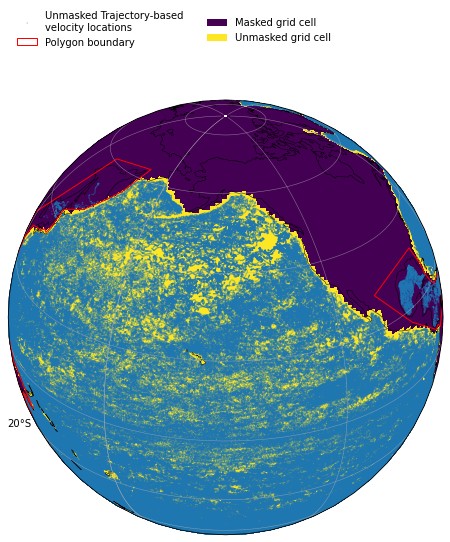

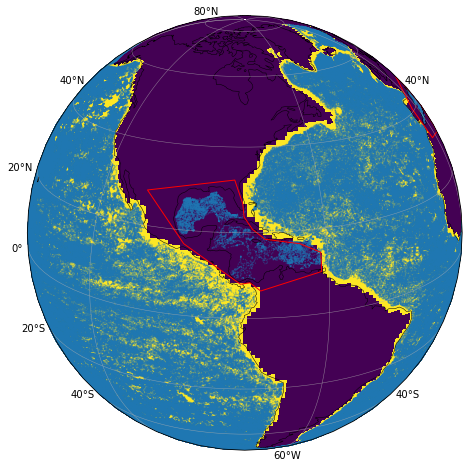

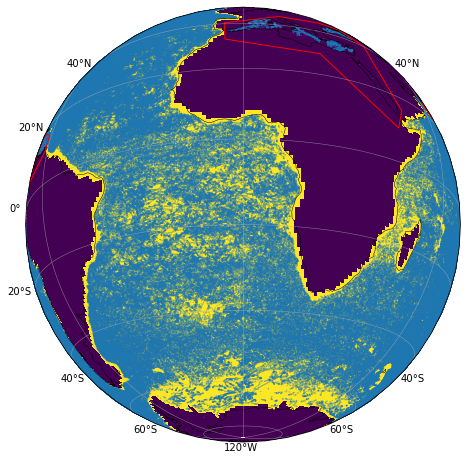

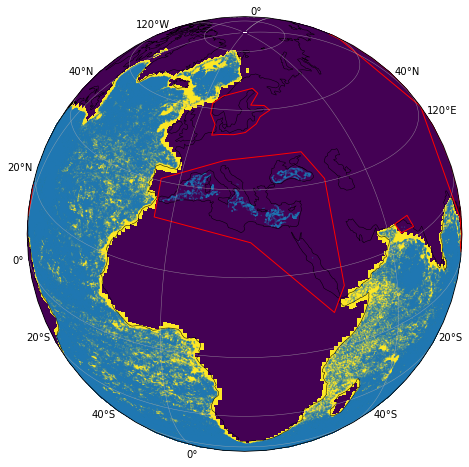

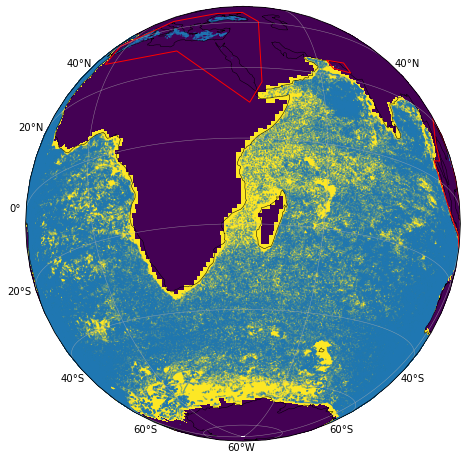

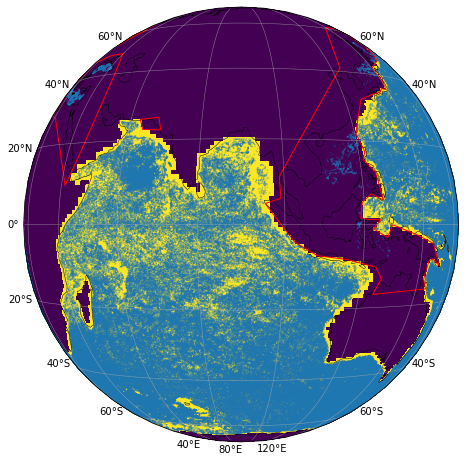

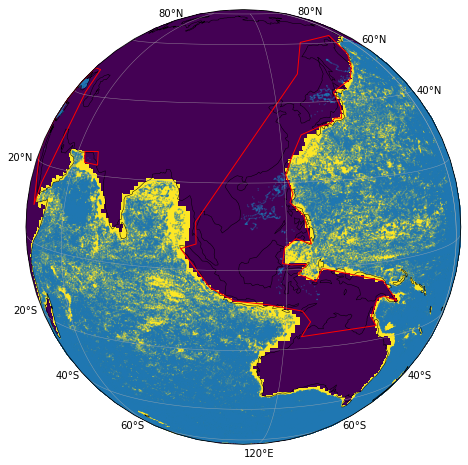

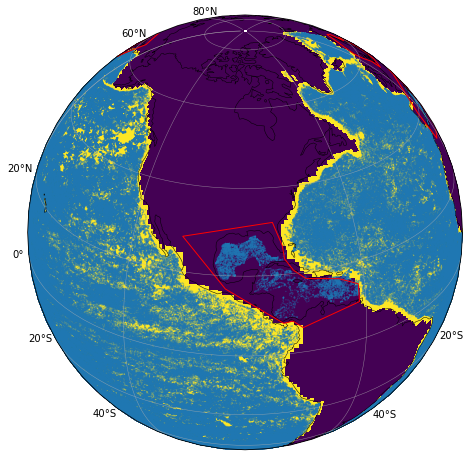

In [6]:
# Plot nearside perspective of the masked parameter grid and trajectory-based velocity locations and polygons on top
# Same plotting as before but with a new projection, getting a final global look

# create a list of central longitude and latitude coordinate pairs to use in the nearside projection to get a look at the entire globe
perspective_locs = [[-150, 30], [-80, 20], [0,-20], [20, 30], [40, -20], [90, 0], [110,10], [270,30]]
for i in range(len(perspective_locs)):
    projection, data_crs = ccrs.NearsidePerspective(perspective_locs[i][0],perspective_locs[i][1]), ccrs.PlateCarree()
    fig,ax = plt.subplots(1,1,figsize=(8,8),subplot_kw={'projection':projection})
    fig.set_facecolor('white')
    # make coastlines thinner
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=True,linewidth=0.5, alpha=0.7)   
    gl.top_labels = False; gl.right_labels = False
    # ax.set_title('Trajectory-based velocity locations over masked parameter grid')

    # Plot masked parameter grid
    masked_parameter_mask.mask.plot(ax=ax,transform=data_crs, add_colorbar=False)

    # Plot trajectory-based velocity locations
    traj_based_vel.plot.scatter(x='longitude', y='latitude', ax=ax, transform=data_crs, s=2, edgecolor='none',alpha=0.4,
            label='Unmasked Trajectory-based \nvelocity locations')

    # Plot polygons
    for polygon in polygons:
        ax.add_geometries([polygon], data_crs, facecolor='none', edgecolor='red')

    if i ==0:
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        handles.append(mpl.patches.Patch(facecolor='none', edgecolor='red'))
        labels.append('Polygon boundary')
        # Add to legend labels 'Masked grid cell' for the color mpl.colormaps['viridis'](0)
        # and 'Unmasked grid cell' for the color mpl.colormaps['viridis'](1)
        for value in [0, 1]:
            handles.append(mpl.patches.Patch(facecolor=mpl.cm.viridis(mpl.colors.Normalize(vmin=0, vmax=1)(value)),
                                            edgecolor='none'))
            labels.append('Masked grid cell' if value == 0 else 'Unmasked grid cell')

        ax.legend(handles, labels, ncol=2, loc='lower left',
                    facecolor='grey', bbox_to_anchor=(0.0, 1.1), frameon=False)

    plt.show()